<a href="https://colab.research.google.com/github/cathemesquita/Colab_notebooks/blob/main/PAC_acoplamento_fase_amplt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from numpy.fft import fft, rfft
from scipy import signal
import math
import scipy.fftpack
from scipy.signal import welch, spectrogram
from scipy.signal import welch, coherence
from scipy.signal import hilbert, chirp


import scipy
import copy
import sys


import time as ttime
from numpy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat

In [ ]:
data= loadmat('/content/drive/MyDrive/SINAIS/LFP-1.mat')

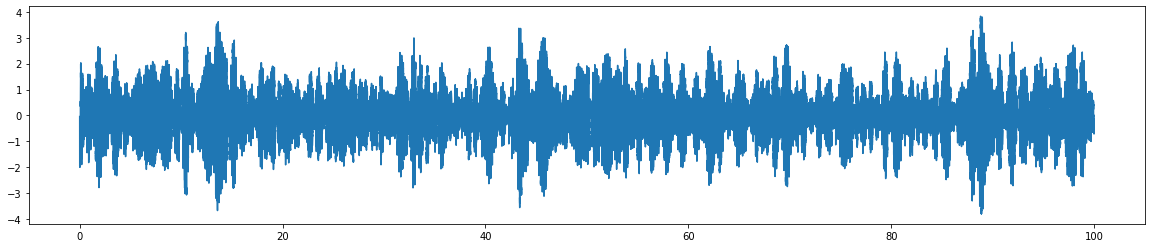

In [ ]:
plt.figure(figsize=(20,4))
plt.plot( data['t'][0], data['LFP'][0])

abaixo pode-se observar o ACOPLAMENTO FASE-AMPLITUDE
* são frequências altas e baixas combinadas

(4.0, 5.0)

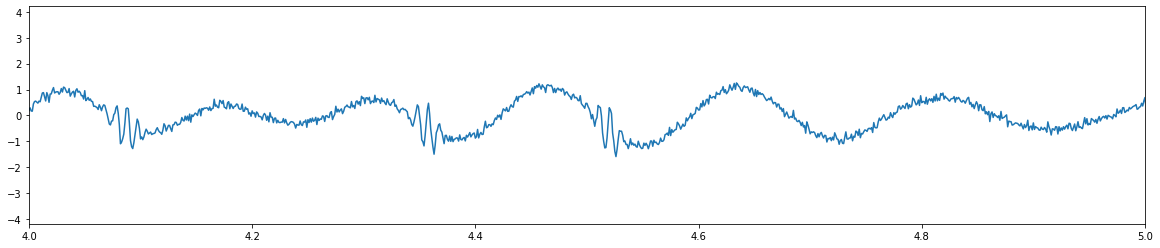

In [ ]:
plt.figure(figsize=(20,4))
plt.plot( data['t'][0], data['LFP'][0])
plt.xlim(4,5)#de novo da para ver 60Hz

In [ ]:
data['LFP'].shape[1]/100 #descobrindo qual foi a taxa de amostragem

1000.0

Text(0.5, 1.0, 'Espectro de Potências')

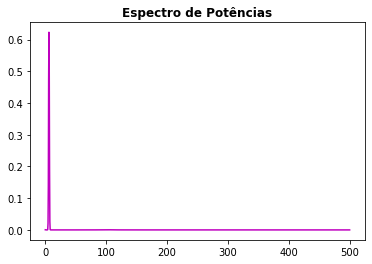

In [ ]:
espectro = data['LFP'][0]

f, p = welch(espectro, fs=1000, nperseg=2000, noverlap=500)
plt.plot(f, p, color='m')
plt.title('Espectro de Potências', fontweight ="bold")
# plt.xlim(0,100)

Text(0.5, 1.0, 'Espectro de Potências')

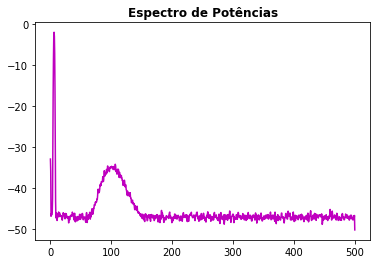

In [ ]:
espectro = data['LFP'][0]

f, p = welch(espectro, fs=1000, nperseg=2000, noverlap=500)
plt.plot(f, 10*np.log10(p), color='m')
plt.title('Espectro de Potências no log', fontweight ="bold") #OLHANDO O ESPECTRO NO LOG É POSSIVEL VER OUTRAS FREQUENCIAS QUE ANTES NÃO ESTAVAM APARECENDO
# plt.xlim(0,100)

Text(0, 0.5, 'Frequencia (Hz)')

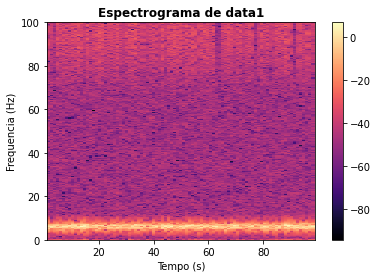

In [ ]:
f, t, Sxx = spectrogram( espectro, fs=1000, nperseg=2000, noverlap=int(0.9*1000) )


plt.pcolormesh(t, f, 10*np.log10(Sxx), cmap='magma') #não ficou bom sem estar em log
plt.ylim(0, 100)
# plt.xlim(0,70)
plt.colorbar()
plt.title('Espectrograma de data1', fontweight ="bold")
plt.xlabel('Tempo (s)')
plt.ylabel('Frequencia (Hz)')

> # CALCULANDO O PAC

* FILTRAR O SINAL NAS DUAS BANDAS DE INTERESSE ( A BAIXA E A ALTA)
* CALCULAR A FASE DA BANDA BAIXA (DE 5 A 7) E A AMPLITUDE DA BANDA ALTA (80 A 120Hz)

In [ ]:
# FILTRO PASSA-BANDA
lower_bnd = 5 # Hz
upper_bnd = 7 # Hz

transw = .1

samprate  = 1000 # Hz
filtorder = 8*np.round(samprate/lower_bnd)+1
if filtorder % 2 == 0:
    filtorder += 1

filter_shape = [ 0,0,1,1,0,0 ]
filter_freqs = [ 0, lower_bnd*(1-transw), lower_bnd, upper_bnd, upper_bnd+upper_bnd*transw, samprate/2 ]

filterkern = signal.firls(filtorder,filter_freqs,filter_shape,fs=samprate)

filt_baixa = signal.filtfilt(filterkern, 1, espectro)

In [ ]:
# FILTRO PASSA-BANDA
lower_bnd = 80 # Hz
upper_bnd = 120 # Hz

transw = .1

samprate  = 1000 # Hz
filtorder = 8*np.round(samprate/lower_bnd)+1
if filtorder % 2 == 0:
    filtorder += 1

filter_shape = [ 0,0,1,1,0,0 ]
filter_freqs = [ 0, lower_bnd*(1-transw), lower_bnd, upper_bnd, upper_bnd+upper_bnd*transw, samprate/2 ]

filterkern = signal.firls(filtorder,filter_freqs,filter_shape,fs=samprate)

filt_alta = signal.filtfilt(filterkern, 1, espectro)

(4.0, 5.0)

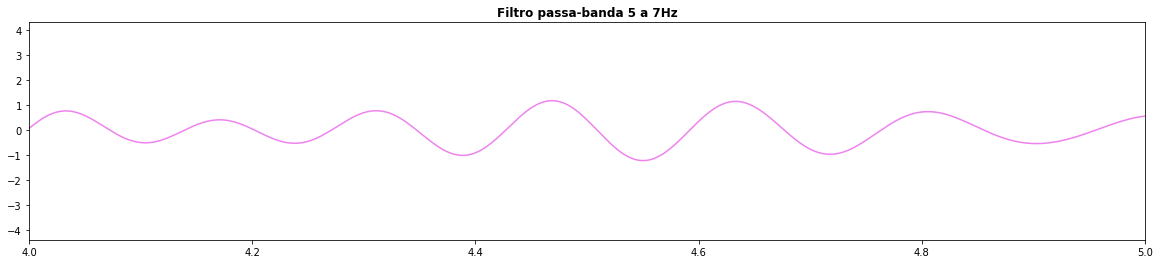

In [ ]:
plt.figure(figsize=(20,4))
plt.plot( data['t'][0], filt_baixa, color = 'violet')

plt.title('Filtro passa-banda 5 a 7Hz', fontweight ="bold")

plt.xlim(4,5)

(4.0, 5.0)

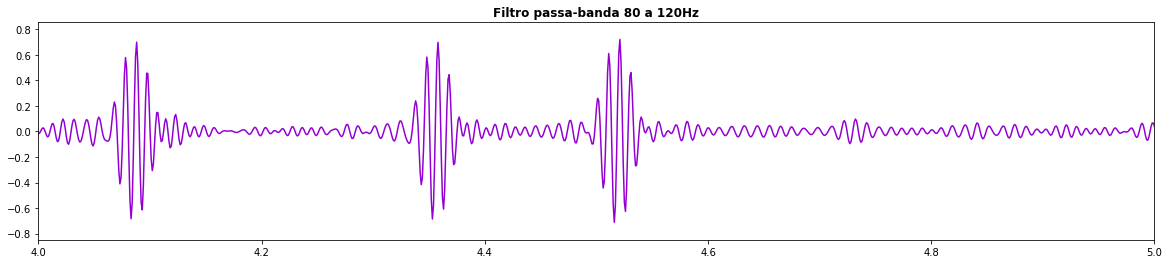

In [ ]:
plt.figure(figsize=(20,4))
plt.plot( data['t'][0], filt_alta, color='darkviolet')
plt.title('Filtro passa-banda 80 a 120Hz', fontweight ="bold")
plt.xlim(4,5)

(4.0, 5.0)

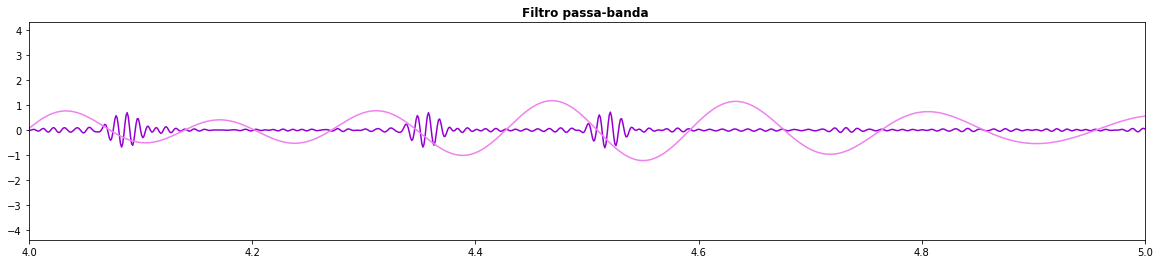

In [ ]:
# agora juntando os dois:

plt.figure(figsize=(20,4))
plt.plot( data['t'][0], filt_alta, color='darkviolet')
plt.plot( data['t'][0], filt_baixa, color = 'violet')

plt.title('Filtro passa-banda ', fontweight ="bold")
plt.xlim(4,5)


> # EXTRAINDO A FASE E A AMPLITUDE

* utilizar a Transformada de Hilbert
* utilizar o comando np.angle fara extrair a FASE DA FREQ BAIXA
* utilizar o comando abs() para extrair a AMPLITUDE DA FREQ ALTA

In [ ]:
fase = np.angle(hilbert(filt_baixa))
amp = abs(hilbert(filt_alta))

(4.0, 5.0)

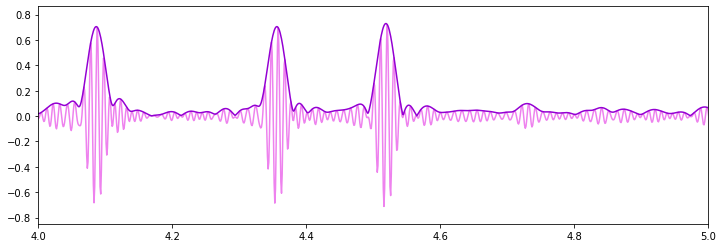

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(data['t'][0], filt_alta, color='violet')
plt.plot(data['t'][0], amp, color='darkviolet')
plt.xlim(4,5)

(4.0, 5.0)

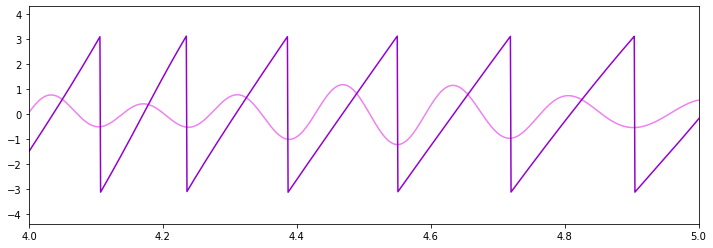

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(data['t'][0], filt_baixa, color='violet')
plt.plot(data['t'][0], fase, color='darkviolet')
plt.xlim(4,5)

> # MEDINDO A RELAÇÃO ENTRE FASE-AMPLITUDE

In [ ]:
# MEDINDO A RELAÇÃO ENTRE FASE-AMPLITUDE (codigo do prof)

bins = np.arange(-np.pi, np.pi, 0.1)
amp_mean = np.zeros( len(bins) -1)
p_mean = np.zeros(len(bins)-1)
for k in range(len(bins)-1):
    limite_inferior = bins[k]
    limite_superior = bins[k+1]
    p_mean[k] = np.mean([limite_inferior, limite_superior])
    amp_mean[k] = np.mean(amp[(fase >=limite_inferior) & (fase <limite_superior) ] )#amplitude em que os valores estão entre o limite sup e inf

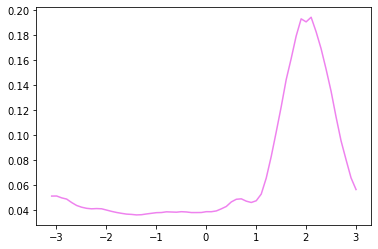

In [ ]:
plt.plot(p_mean,amp_mean, color='violet') #pode-se observar que existe um pico quando a fase está em 2, então há uma relação entre fase-amplitude

In [ ]:
! pip install pactools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 917 kB/s 
     |████████████████████████████████| 7.6 MB 14.2 MB/s 


In [ ]:
import pactools
from pactools import Comodulogram, REFERENCES

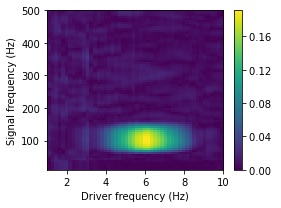

In [ ]:
# MEDINDO A RELAÇÃO ENTRE FASE-AMPLITUDE (função pronta) #é essa que é para usar!!!

low_fq_range = np.linspace(1, 10, 50) # aqui está escrito que o filtro baixo será de frequencia 1 a 10Hz com um intervalo de 50

estimator = Comodulogram(fs=1000, low_fq_range=low_fq_range,
                             low_fq_width=1, method='ozkurt',
                             progress_bar=False)
estimator.fit(data['LFP'][0])
estimator.plot( )

plt.show()